In [1]:
!ls

data			    new_tutorial.ipynb	tutorial_data.txt  tutorial.log
example_demographies.ipynb  new_tutorial.log	tutorial.ipynb


In [2]:
import momi
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(level=logging.INFO, filename="new_tutorial.log")

In [3]:
# empty model with N_e=1.2e4, 29 time units (years) per generation
model = momi.demographic_model(default_N=1.2e4, gen_time=29)
# add YRI leaf at t=0 and default_N
model.add_leaf("YRI")
# add  CHB leaf at t=0, N=1e5, growing at rate 1e-3 per unit time (year)
model.add_leaf("CHB", N=1e5, g=5e-4)
# add NEA leaf at 50kya
model.add_leaf("NEA", t=5e4)

# stop CHB growth at 10kya
model.set_size("CHB", g=0, t=1e4)

# at 45kya CHB receive a 3% pulse from GhostNea
model.move_lineages("CHB", "GhostNea", t=4.5e4, p=.03)
# at 55kya GhostNea joins onto NEA
model.move_lineages("GhostNea", "NEA", t=5.5e4)

# at 80 kya CHB goes thru bottleneck
model.set_size("CHB", N=100, t=8e4)
# at 85 kya CHB joins onto YRI
model.move_lineages("CHB", "YRI", t=8.5e4)

# at 500 kya YRI joins onto NEA
model.move_lineages("YRI", "NEA", t=5e5)

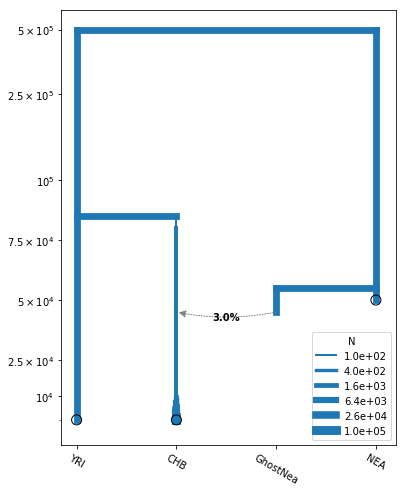

In [4]:
# plot the model
plt.figure(figsize=(6,8))
model.draw(["YRI", "CHB", "GhostNea", "NEA"], # specfiy pop order along the x-axis
            linthreshy=1e5) # linear scale up to 1e5, then logarithmic
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])

In [5]:
import gzip
import os

per_base_mut_rate = 1.25e-8
per_base_recom_rate = 1.25e-8
bases_per_locus = int(5e5)
n_loci = 20
ploidy = 2

# number of alleles to sample per population
sampled_n_dict = {"NEA":2, "YRI":4, "CHB":4}

# create data directory if it doesn't exist
os.makedirs("data", exist_ok=True) 

In [6]:
# simulate 20 "chromosomes", saving each in a separate gzipped vcf file
for chrom in range(n_loci):
    with gzip.open("data/{}.vcf.gz".format(chrom), "wt") as outfile:
        model.simulate_vcf(
            outfile,
            mutation_rate=per_base_mut_rate,
            recombination_rate=per_base_recom_rate,
            length=bases_per_locus,
            chrom_names=["chr{}".format(chrom)],
            ploidy=ploidy,
            random_seed=1234+chrom,
            sampled_n_dict=sampled_n_dict) 

In [7]:
## read in data from vcf

## first create a dict mapping samples to populations
ind2pop = {}
for pop, n in sampled_n_dict.items():
    for i in range(int(n / ploidy)):
        ## in the simulated vcfs, the samples are named like YRI_0, YRI_1, CHB_0, etc
        ind2pop["{}_{}".format(pop, i)] = pop

# uses REF as the ancestral allele
ancestral_alleles = False
## Other options:
## True: use the "AA" INFO field as the anc allele (skipping SNPs without this field)
## population name: use this population as the outgroup for polarizing

# Read in each vcf in a for loop
data = []
for chrom in range(n_loci):
    with gzip.open("data/{}.vcf.gz".format(chrom), "rt") as f:
        data.append(momi.SnpAlleleCounts.read_vcf(f, ind2pop,
                                                  ancestral_alleles))

# concatenate the 20 loci into a single dataset
data = momi.SnpAlleleCounts.concatenate(data)


In [8]:
## dump the momi-style data to a json file
with gzip.open("data/momi_data.json.gz", "wt") as f:
    data.dump(f)

## load the data back from the json file
with gzip.open("data/momi_data.json.gz", "rt") as f:
    data2 = momi.SnpAlleleCounts.load(f)

assert data == data2

In [9]:
## INFERENCE

## create a new model
model2 = momi.demographic_model(default_N=1.2e4, gen_time=29)

## set the data
model2.set_data(data,
                # use multinomial model, unfolded SFS
               muts_per_gen=None, folded=False,
                # splits data into 100 equally sized blocks
                # used to compute standard deviation of f4 and other stats
                # via block jackknife
               n_blocks_jackknife=100)

In [10]:
## start by fitting CHB and YRI

## define parameters of the model
#model2.add_size_param("n_chb", 1.2e4)
#model2.add_growth_param("g_chb", 0, lower=-1e-3, upper=1e-3)
#model2.add_time_param("t_chb_yri", 1e5, lower=1e4)
model2.add_size_param("n_chb")
model2.add_growth_param("g_chb", 0, lower=-1e-3, upper=1e-3)
model2.add_time_param("t_chb_yri", lower=1e4)

## add demographic events
model2.add_leaf("CHB", N="n_chb", g="g_chb")
model2.add_leaf("YRI")
model2.set_size("CHB", t=1e4, g=0)
model2.move_lineages("CHB", "YRI", t="t_chb_yri")

In [11]:
#model2.optimize(method="L-BFGS-B")
model2.optimize(method="TNC")

     fun: 0.0012543359463144696
     jac: array([ 4.32811352e-06, -3.94514467e-02, -9.77396645e-10])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 60
     nit: 28
  status: 1
 success: True
       x: array([1.43396880e+01, 7.60424164e-04, 1.03529727e+05])

In [12]:
print(model2.get_params())

ParamsDict({'n_chb': 1689068.9532654493, 'g_chb': 0.0007604241644012747, 't_chb_yri': 113529.72697127191})


/home/jack/Source/private/momi_projects/momi2/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


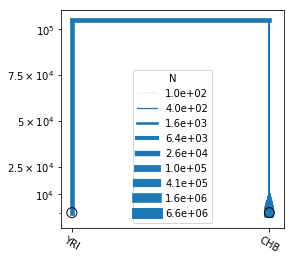

In [13]:
# plot the model
plt.figure(figsize=(4,4))
model2.draw(["YRI", "CHB"], linthreshy=1e5)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5])

In [14]:
## add NEA to the model

model2.add_leaf("NEA", t=5e4)

#model2.add_time_param("t_anc", 5e5,
#                      lower_constraints=["t_chb_yri"])
model2.add_time_param("t_anc", lower_constraints=["t_chb_yri"])

model2.move_lineages("YRI", "NEA", t="t_anc")

In [15]:
model2.optimize()

     fun: 0.012457109368940183
     jac: array([ 8.30589563e-07, -8.45594546e-03,  1.39769468e-11, -4.43826253e-13])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 73
     nit: 19
  status: 1
 success: True
       x: array([7.51883227e+00, 7.24560575e-05, 9.96107563e+04, 3.33430965e+05])

/home/jack/Source/private/momi_projects/momi2/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


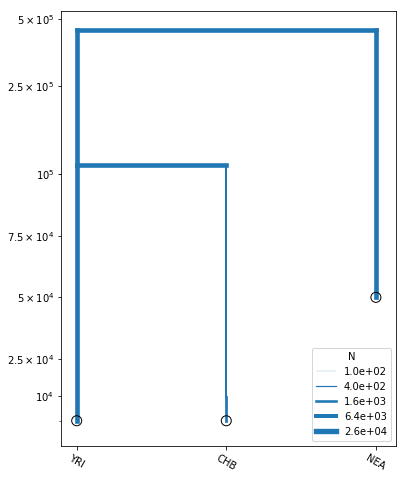

In [16]:
# plot the model
plt.figure(figsize=(6,8))
model2.draw(["YRI", "CHB", "NEA"], linthreshy=1e5)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])

In [17]:
# model diagnostics
fstats = model2.fstats()
# f4(YRI, CHB, NEA, AncestralAllele) < 0 because of unmodeled Neanderthal admixture
# z_score is not significant because we only have a small dataset here
print(fstats.f4("YRI", "CHB", "NEA", None))

# also some functionality to check other statistics
# e.g. f2, f3, distance between every pair of populations
# (TODO: easily plot residuals of all pairwise distances)

ModelFitArray(expected=-3.469446951953614e-18, observed=-0.005661024702653249, sd=0.0028238767826156788, z_score=-2.004699616323059)


In [18]:
## create a new model with added NEA->CHB pulse

add_pulse_model = model2.copy()

#add_pulse_model.add_pulse_param("p_pulse", .1)
#add_pulse_model.add_time_param("t_pulse", 5e4, upper_constraints=["t_chb_yri"])
add_pulse_model.add_pulse_param("p_pulse", upper=.25)
add_pulse_model.add_time_param("t_pulse", upper_constraints=["t_chb_yri"])

add_pulse_model.move_lineages("CHB", "GhostNea", t="t_pulse", p="p_pulse")

#add_pulse_model.add_time_param("t_ghost", 1e5, lower=5e4, lower_constraints=["t_pulse"], upper_constraints=["t_anc"])
add_pulse_model.add_time_param("t_ghost", lower=5e4, lower_constraints=["t_pulse"], upper_constraints=["t_anc"])
add_pulse_model.move_lineages("GhostNea", "NEA", t="t_ghost")

/home/jack/.local/share/virtualenvs/momi2-gAXri9wX/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [19]:
# stochastic gradient descent (ADAM+SVRG)
add_pulse_model.stochastic_optimize(snps_per_minibatch=1000, num_iters=10, svrg_epoch=3)

     fun: 3.6600356521580024
     jac: array([ 1.91226083e-02, -1.98292834e+01, -2.04233999e-07, -1.44064899e-07,
        5.48476561e-02, -7.97645915e-05, -4.43836226e-03])
 message: 'Maximum number of iterations reached'
     nit: 9
 success: False
       x: array([ 7.53754553e+00, -1.00000000e-03,  9.96105669e+04,  3.33431756e+05,
       -2.39724138e+00,  1.90311801e+00,  5.52923282e-01])

In [20]:
# full gradient descent
add_pulse_model.optimize(method="TNC")

     fun: 0.0045862806703605785
     jac: array([-3.62223467e-03,  3.50352058e+01,  3.69419174e-08, -9.09830307e-09,
       -8.88777545e-04,  5.29420413e-04,  3.63267928e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 14
  status: 3
 success: False
       x: array([ 9.42579538e+00,  3.13025587e-04,  8.37786380e+04,  3.67822480e+05,
       -2.79334082e+00, -6.35815377e-01, -3.51088974e+00])

/home/jack/Source/private/momi_projects/momi2/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


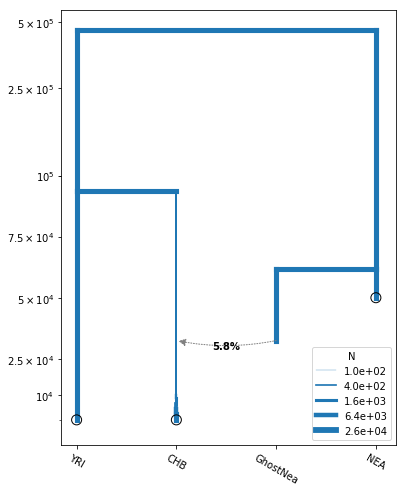

In [21]:
# plot the model
plt.figure(figsize=(6,8))
add_pulse_model.draw(["YRI", "CHB", "GhostNea", "NEA"], linthreshy=1e5)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])

In [24]:
## generate nonparametric bootstrap datasets

n_bootstraps = 20
bootstrap_mles = []

# split dataset into 100 equally sized blocks to resample
chunked_data = data.chunk_data(100)

bootstrap_model = add_pulse_model.copy()
for bootstrap_it in range(n_bootstraps):
    print(bootstrap_it)
    # bootstrap resample blocks
    bootstrap_data = chunked_data.resample_chunks()
    
    bootstrap_model.set_data(bootstrap_data)
    # TODO: bootstrap_model.set_x(some_random_x0)
    bootstrap_model.set_random_parameters()
    bootstrap_model.optimize()
    bootstrap_mles.append(bootstrap_model.get_x())

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


/home/jack/Source/private/momi_projects/momi2/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


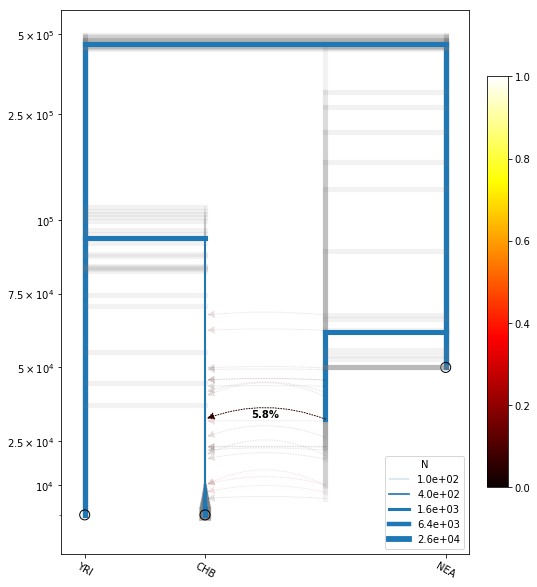

In [25]:
plt.figure(figsize=(8,10))
add_pulse_model.draw_with_bootstraps(bootstrap_mles,
                                     ["YRI", "CHB", "GhostNea", "NEA"], 
                                     linthreshy=1e5, p_min=0, p_max=1)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])

/home/jack/pythonpath/momi/demo_plotter.py:35: RuntimeWarning: invalid value encountered in double_scalars
  -self.curr_g * (nxt_t - self.curr_t))


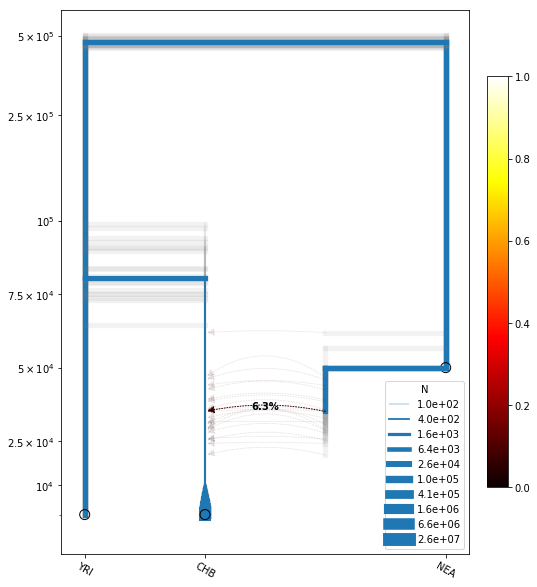

In [ ]:
plt.figure(figsize=(8,10))
add_pulse_model.draw_with_bootstraps(bootstrap_mles,
                                     ["YRI", "CHB", "GhostNea", "NEA"], 
                                     linthreshy=1e5, p_min=0, p_max=1)
plt.gca().set_yticks([1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5])